In [1]:
import os
import cv2
import glob
import pickle
import time

import numpy as np
from numpy import arange 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

from scipy import signal
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

#%matplotlib qt
%matplotlib inline

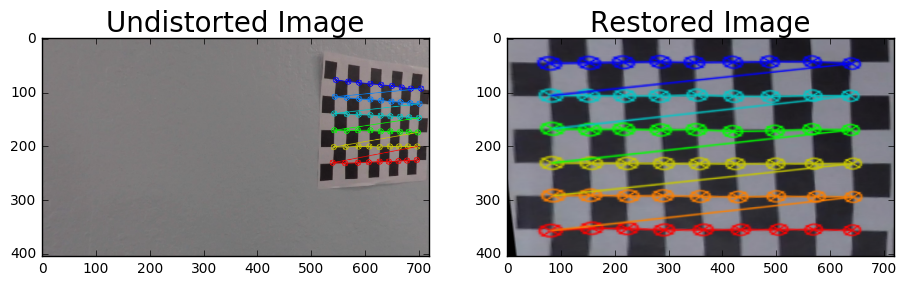

In [2]:
# Reload the camera calibration matrix and distortion conefficients 
scale = 720/1280 # Scale the 1280 image down to 720 image
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/720x540_cal_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
# Read in an image
img = cv2.imread('camera_cal/calibration14.jpg')
rows, cols, chs = img.shape
img = cv2.resize(img,(int(cols*scale),int(rows*scale)))
#img = cv2.resize(img,(720,405))
undist = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
rows, cols, chs = img.shape
#print(rows, cols)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
#print (corners[0], corners[-nx], corners[-1], corners[nx-1])
#print('Object point coordinates:', objp[-1], objp[-nx], objp[0], objp[nx-1])
#print ('Actual corners coordinates:', corners[-1], corners[-nx], corners[0], corners[nx-1])
# If found, add object points, image points
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
    
    offsetx = 80 # offset columns for dst points
    offsety = 48 # offset rows for dst points
    
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([corners[-1], corners[-nx], corners[0], corners[nx-1]]) # 180 deg rotation
    #src = np.float32([corners[nx-1],corners[0], corners[-nx], corners[-1]])  # zero deg rotation
    
    dst = np.float32([[offsetx, offsety], [cols-offsetx, offsety], 
                                     [cols-offsetx, rows-offsety], 
                                     [offsetx, rows-offsety]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M,(cols, rows))


display = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(undist,cmap='gray')
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(display,cmap='gray')
ax2.set_title('Restored Image', fontsize=20)

In [298]:
class process:
    
    def __init__(self, image, scale, mtx, dist):

        self.image = image
        self.rows, self.cols, self.chs = image.shape
        self.scale = scale
        self.mtx = mtx
        self.dist = dist
        self.orient = 'x'
        self.apex, self.apey = 360, 240 # Udacity Class Camera
        self.offset_far = 170 #Setup marginal pixels at apex point
        #offset_near = -750
        self.offset_near = -1250 # Marginal pixels at bottom of the image
        self.dsize = (720, 405)

        self.src = np.float32([[int(self.apex-self.offset_far),self.apey],[int(self.apex+self.offset_far),self.apey],\
                               [int(0+self.offset_near),400],[int(720-self.offset_near),400]])
        self.dst = np.float32([[0,0],[720,0],[0,405],[720,405]])
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Mi = cv2.getPerspectiveTransform(self.dst, self.src)
        self.grad_thresh=(25,130)
        self.sobel_kernel=3
        self.mag_thresh=(50, 255)
        self.canny_thresh = (50, 150)
        self.color=[255, 0, 0]
        self.thickness=4
        self.lines = []
        
        # Define the Hough transform parameters
        self.rho = 1 # distance resolution in pixels of the Hough grid
        self.theta = np.pi/180 # angular resolution in radians of the Hough grid
        self.hough_thresh = 10     # minimum number of votes (intersections in Hough grid cell)
        self.min_line_len = 18 #minimum number of pixels making up a line
        self.max_line_gap = 1    # maximum gap in pixels between connectable line segments
        
    def resize(self):
        return cv2.resize(self.image,(int(self.cols*self.scale),int(self.rows*self.scale)))
    
    def undist(self):
        self.undist = cv2.undistort(self.resize(), self.mtx, self.dist, None, self.mtx)
        return self.undist
        
    def perspective_transform(self): 
        # Take undistort image and warp to bird view
        warped = cv2.warpPerspective(self.undist(), self.M, self.dsize, flags = cv2.INTER_LINEAR)
        return warped
    
    def abs_sobel_thresh(self): # Define a function that takes an image, gradient orientation
        # Convert to grayscale
        gray = cv2.cvtColor(self.resize(), cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if self.orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if self.orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= self.grad_thresh[0]) & (scaled_sobel <= self.grad_thresh[1])] = 1
        return binary_output
    
    
    def mag_thresh(self): # Define a function to return the magnitude of the gradient
        # Convert to grayscale
        gray = cv2.cvtColor(self.resize(), cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= self.mag_thresh[0]) & (gradmag <= self.mag_thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    def draw_hough_lines(self):
        #line_img = np.zeros((self.canny().shape, 3), dtype=np.uint8)
        output = np.zeros_like(self.canny())
        lines = self.hough_lines() 
        #car_marker = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                if (x2-x1) != 0:   # Make sure do not divide by zero
                    if abs(y2-y1)/(x2-x1) < 12 and min(y1, y2) > 100: 
                                                
                        line_img = cv2.line(output, (x1,y1), (x2, y2), self.color, self.thickness)
        return line_img
    
    def canny(self):
        gray = cv2.cvtColor(self.resize(), cv2.COLOR_RGB2GRAY)
        return cv2.Canny(gray, self.canny_thresh[0], self.canny_thresh[1])
    
    def hough_lines(self):
        hough = cv2.HoughLinesP(self.canny(), self.rho, self.theta, self.hough_thresh, np.array([]),\
                                minLineLength=self.min_line_len, maxLineGap=self.max_line_gap)
        return hough
    
    def unwarp(self):
        unwarp = perspective_transform(radar, Mi)
    
    def car_marker(self):
        warped = self.perspective_transform()
        gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
        canny = cv2.Canny(gray, self.canny_thresh[0], self.canny_thresh[1])
        warp_zero = np.zeros_like(warped)
        hough = cv2.HoughLinesP(canny, self.rho, self.theta, self.hough_thresh, np.array([]),\
                                minLineLength=self.min_line_len, maxLineGap=self.max_line_gap)
        global line_img
        for line in hough:
            for x1,y1,x2,y2 in line:
                if (x2-x1) != 0: # Make sure do not divid by zero
                    # filter out extra lines, keep only interested region. 
                    if -1.99<(y2-y1)/(x2-x1)< 1.99 and 200<max(y1,y2)<380 and 70<min(x1,x2) and max(x1,x2)<650:
                                                       
                        line_img = cv2.line(warp_zero, (x1, y1), (x2, y2), self.color, self.thickness)
        
        unwarped = cv2.warpPerspective(line_img, self.Mi, self.dsize, flags = cv2.INTER_LINEAR)
        # Combine the result with the original image, with random brightness
        random_bright = np.random.uniform(0.1,1)
        result = cv2.addWeighted(self.resize(), random_bright, unwarped, 0.9, 0)
        #result = cv2.addWeighted(self.resize(), 1, unwarped, 0.9, 0)
    
        return unwarped


In [4]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def pipeline(img):
    marker = process(img, scale, mtx, dist)
    return process.car_marker(marker)

write_output = './test_video_out3.mp4'
clip1 = VideoFileClip('./test_video.mp4')
write_clip = clip1.fl_image(pipeline)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)


[MoviePy] >>>> Building video ./test_video_out3.mp4
[MoviePy] Writing video ./test_video_out3.mp4


 97%|█████████▋| 38/39 [00:02<00:00, 18.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out3.mp4 

CPU times: user 8.98 s, sys: 76 ms, total: 9.06 s
Wall time: 2.74 s


In [5]:
HTML("""
<video width="720" height="405" controls>
  <source src="{0}">
</video>
""".format(write_output))

In [6]:
class detector(process):
    #pass
    #Hog feature 
    
    def __init__(self, image, scale, mtx, dist, n_clusters, template_list=None, color_space='RGB',size=(32, 32),
                vis=False, feature_vec=True, hog_channel = 0):
        super().__init__(image, scale, mtx, dist)
        self.n_clusters = n_clusters
        # Define the Hough transform parameters
        self.rho = 1             # distance resolution in pixels of the Hough grid
        self.theta = np.pi/180   # angular resolution in radians of the Hough grid
        self.hough_thresh = 10   # minimum number of votes (intersections in Hough grid cell)
        self.min_line_len = 30   # minimum number of pixels making up a line
        self.max_line_gap = 1    # maximum gap in pixels between connectable line segments
        self.template_list = template_list #template match source
        self.color_space = color_space   #color space
        self.size = size         # dst image size
        # Define the HOG Feature parameters
        self.orient = 9                 
        self.pix_per_cell = (8,8)           
        self.cell_per_block = (2,2)
        self.hog_channel = 0  # Could be 0, 1, 2, ALL
        # Turn on and off the visilation and feature vector
        self.vis = vis          
        self.feature_vec = feature_vec
        # training dataset
        # self.dataset_imgs = dataset_imgs
        
        
        
    def kmeans_pipeline(self):
        t0 = time.time()
        warped = self.perspective_transform()
        gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
        canny = cv2.Canny(gray, self.canny_thresh[0], self.canny_thresh[1])
        warp_zero = np.zeros_like(warped)
        
        hough = cv2.HoughLinesP(canny, self.rho, self.theta, self.hough_thresh, np.array([]),\
                                minLineLength=self.min_line_len, maxLineGap=self.max_line_gap)
        X = [] 
        for line in hough:
            for x1,y1,x2,y2 in line:
                if (x2-x1) != 0:
                    if abs((y2-y1)/(x2-x1))< 12 and min(y1,y2)>100 :
                        X.append([min(x1,x2),max(y1,y2)])
                        #X.append([x1,y1])
                        #X.append([x2,y2])
                #line_img = cv2.line(warp_zero, (x1, y1), (x2, y2), (255,0,0), self.thickness)
        #print (len(X))
        if len(X) > n_clusters:
            
            k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=20)
            k_means.fit(X)
            k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
            k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
        t_batch = time.time() - t0
        #print (t_batch)
        car_dist = []
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/405 # meters per pixel in y dimension
        xm_per_pix = 3.7/150 # meteres per pixel in x dimension
        box = k_means_cluster_centers
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        for k in range(len(box)):
            k_res = cv2.rectangle(warp_zero, (int(box[k][0]-15),int(box[k][1]-25)), \
                                     (int(box[k][0]+55),int(box[k][1]+25)), (255,255,0), 10)
            #curve = cv2.line(warp_zero, (int(box[k][0]),int(box[k][1]+50)), (320, 410), color=[255,0,0], thickness=2)
            distance = np.sqrt(((box[k][0]-320)*xm_per_pix)**2+((box[k][1]-410)*ym_per_pix)**2)
            car_dist.append(distance)
            #cv2.putText(warp_zero,'Car%s:%.1fm' % (k, distance),\
            #            (int(box[k][0]-30),int(box[k][1]-40)), font, 1,(255,255,255),2)
        unwarped = cv2.warpPerspective(warp_zero, self.Mi, self.dsize, flags = cv2.INTER_LINEAR)
        # Combine the result with the original image
        result = cv2.addWeighted(self.resize(), 1, unwarped, 1, 0)
    
        return result
    
    
    def find_matches(self):
        # Define a function to search for template matches and return a list of bounding boxes
        # Define an empty list to take bbox coords
        global bbox_list
        bbox_list = []
        # Define matching method
        # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
        #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
        method = cv2.TM_CCOEFF_NORMED
        #bbox_img = self.resize()
        # Iterate through template list
        for temp in self.template_list:
            # Read in templates one by one
            #tmp = mpimg.imread(temp)
            # Use cv2.matchTemplate() to search the image
            result = cv2.matchTemplate(self.resize(), temp, method)
            # Use cv2.minMaxLoc() to extract the location of the best match
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
            # Determine a bounding box for the match
            w, h = (temp.shape[1], temp.shape[0])
            if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                top_left = min_loc
            else:
                top_left = max_loc
            bottom_right = (top_left[0] + w, top_left[1] + h)
            # Append bbox position to list
            bbox_list.append((top_left, bottom_right))
            # Draw the bbox back to image
            
            #bbox_img = cv2.rectangle(self.resize(), top_left, bottom_right, (255,255,0), 4)
            # Return the list of bounding boxes
        
        return bbox_list, result

    def is_point_in_bbox(self, point, bbox):
        # Is detection in the window or box
        x, y = point
        x1, y1 = bbox[0]
        x2, y2 = bbox[1]
        
        x_in_range = x1 < x < x2 #True or False
        y_in_range = y1 < y < y2 #True or False

        return x_in_range and y_in_range
    
    def draw_boxes(self):
        # Make a copy of the image
        imcopy = np.copy(self.resize())
        # Iterate through the bounding boxes
        for bbox in bbox_list:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], (255,0,255), 6)
        # Return the image copy with boxes drawn
        return imcopy
    
    
    def color_hist(self): 
        # Define a function to compute color histogram features  
        nbins=32
        bins_range=(0, 256)
        # Compute the histogram of the RGB channels separately
        rhist = np.histogram(self.image[:,:,0], bins=nbins, range=bins_range)
        ghist = np.histogram(self.image[:,:,1], bins=nbins, range=bins_range)
        bhist = np.histogram(self.image[:,:,2], bins=nbins, range=bins_range)
        # Generating bin centers
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return rhist, ghist, bhist, bin_centers, hist_features
    
    def bin_spatial(self):
        #color_space='RGB'
        #size=(32, 32)
        # Convert image to new color space (if specified)
        if self.color_space != 'RGB':
            if self.color_space == 'HSV':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2HSV)
            elif self.color_space == 'LUV':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2LUV)
            elif self.color_space == 'HLS':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)
            elif self.color_space == 'YUV':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2YUV)
            elif self.color_space == 'YCrCb':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(self.image)             
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, self.size).ravel() 
        # Return the feature vector
        return features
    
    
    def get_hog_features(self):
        # Define a function to return HOG features and visualization
        transform_sqrt=False
        if self.vis == True:
            features, hog_image = hog(self.image, orientations=self.orient,
                                      pixels_per_cell= self.pix_per_cell,
                                      cells_per_block= self.cell_per_block, 
                                      transform_sqrt=False, visualise=True, feature_vector=self.feature_vec)
            return features, hog_image
        else:      
            features = hog(self.image, orientations=self.orient, pixels_per_cell= self.pix_per_cell,
                           cells_per_block= self.cell_per_block, transform_sqrt=False,
                           visualise=False, feature_vector=self.feature_vec)
            return features, self.image
        
    def extract_hog_features(self):
        
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in self.dataset_imgs:
            # Read in each one by one
            image = mpimg.imread(file)
            # apply color conversion if other than 'RGB'
            if self.color_space != 'RGB':
                if self.color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif self.color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif self.color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif self.color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif self.color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)      

            # Call get_hog_features() 
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(self.get_hog_features(self))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = self.get_hog_features(self)
            # Append the new feature vector to the features list
            features.append(hog_features)
        # Return list of feature vectors
        return features
    
    def single_img_features(self):
        # Create a list to append feature vectors to
        features = []
        
        # Resize to (64, 64)
        #image = cv2.resize(image,(64,64))
        # apply color conversion if other than 'RGB'
        if self.color_space != 'RGB':
            if self.color_space == 'HSV':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2HSV)
            elif self.color_space == 'LUV':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2LUV)
            elif self.color_space == 'HLS':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)
            elif self.color_space == 'YUV':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2YUV)
            elif self.color_space == 'YCrCb':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        hog_features = self.get_hog_features()
        # Append the new feature vector to the features list
        features.append(hog_features)
        # Return list of feature vectors
        return features


In [7]:
# Credit to https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/master/final-project.ipynb
class Params():
    def __init__(
        self, 
        colorspace='YCrBr',
        orient=9,
        pix_per_cell=4, 
        cell_per_block=4, 
        hog_channel='ALL',
        spatial_size=(32, 32),
        hist_bins=32,
        spatial_feat=True,
        hist_feat=True,
        hog_feat=True
    ):
        self.colorspace = colorspace # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = orient # typically between 6 and 12
        self.pix_per_cell = pix_per_cell # HOG pixels per cell
        self.cell_per_block = cell_per_block # HOG cells per block
        self.hog_channel = hog_channel # Can be 0, 1, 2, or "ALL"
        self.spatial_size = spatial_size # Spatial binning dimensions
        self.hist_bins = hist_bins # Number of histogram bins
        self.spatial_feat = spatial_feat # Spatial features on or off
        self.hist_feat = hist_feat # Histogram features on or off
        self.hog_feat = hog_feat  # HOG features on or off

In [8]:
# Read in car and non-car images
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')
# Use as much sample as possible, and cars and not cars has same number of samples.
sample_size = min(len(cars), len(notcars)) 
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]


In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [10]:
def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [13]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [14]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [18]:
################################################################################################################
# params = Params(colorspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0) #97.5%
# params = Params(colorspace='YUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0) #98.7%
# params = Params(colorspace='YUV', orient=8, pix_per_cell=8, cell_per_block=2, hog_channel=0) #98%
# params = Params(colorspace='YUV', orient=8, pix_per_cell=8, cell_per_block=2, hog_channel='ALL') #Crashed
# params = Params(colorspace='YUV', orient=8, pix_per_cell=7, cell_per_block=2, hog_channel='ALL') #99%
params = Params(colorspace='YCrCb', orient=8, pix_per_cell=7, cell_per_block=2, hog_channel='ALL') #99.01%
# params = Params(colorspace='YCrCb', orient=7, pix_per_cell=4, cell_per_block=2, hog_channel='ALL') #99-100%
# params = Params(colorspace='YCrCb', orient=9, pix_per_cell=4, cell_per_block=4, hog_channel='ALL') #Crashed
# params = Params(colorspace='YCrCb', orient=7, pix_per_cell=8, cell_per_block=2, hog_channel='ALL') #97.46%
################################################################################################################

t=time.time()
car_features = extract_features(cars, color_space=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)
notcar_features = extract_features(notcars, color_space=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)
"""

car_features = extract_hog_features(cars, cspace=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)
notcar_features = extract_hog_features(notcars, cspace=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)
"""
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', params.orient,'orientations',params.pix_per_cell,
    'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

124.46 Seconds to extract HOG features...
Using: 8 orientations 7 pixels per cell and 2 cells per block
Feature vector length: 9312
38.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9903
My SVC predicts:  [ 1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
0.004 Seconds to predict 10 labels with SVC


In [19]:
train_acc = svc.score(X_train,y_train)
test_acc = svc.score(X_test,y_test)
print('Training accuracy: ',train_acc)
print('Testing accuracy: ',test_acc)

Training accuracy:  1.0
Testing accuracy:  0.990332669889


In [20]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [25]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

55
[((1208, 380), (1272, 444)), ((856, 380), (920, 444)), ((1016, 412), (1080, 476)), ((600, 380), (664, 444)), ((984, 412), (1048, 476)), ((1240, 380), (1304, 444)), ((664, 380), (728, 444)), ((1192, 380), (1256, 444)), ((696, 412), (760, 476)), ((760, 412), (824, 476)), ((1224, 380), (1288, 444)), ((648, 412), (712, 476)), ((1048, 412), (1112, 476)), ((680, 412), (744, 476)), ((776, 380), (840, 444)), ((824, 412), (888, 476)), ((1224, 380), (1288, 444)), ((888, 380), (952, 444)), ((840, 412), (904, 476)), ((1016, 380), (1080, 444)), ((1240, 412), (1304, 476)), ((1144, 412), (1208, 476)), ((1112, 380), (1176, 444)), ((760, 412), (824, 476)), ((1176, 380), (1240, 444)), ((1112, 412), (1176, 476)), ((696, 412), (760, 476)), ((600, 412), (664, 476)), ((840, 412), (904, 476)), ((968, 380), (1032, 444)), ((738, 440), (866, 520)), ((930, 440), (1058, 520)), ((482, 440), (610, 520)), ((1058, 400), (1186, 480)), ((482, 440), (610, 520)), ((1154, 400), (1282, 480)), ((930, 440), (1058, 520)), 

<function matplotlib.pyplot.show>

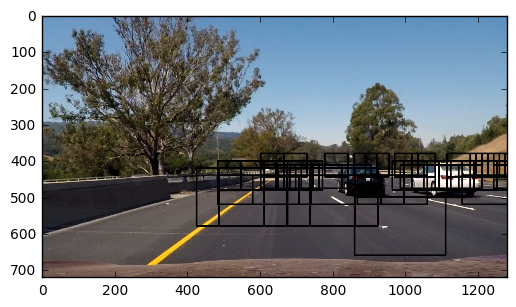

In [320]:
def random_scan_boxes(image, far = 10, mid = 5, near = 3):
    #Create a list to append scan window coordinates
    scan_windows = []
    w_far = slide_window(image, x_start_stop=[600, None], y_start_stop=[380, 500], \
                         xy_window=(64,64), xy_overlap=(0.75, 0.5))
    for i in range (far):
        f = np.random.randint(0, len(w_far))
        scan_windows.append(w_far[f])
        #window_img = draw_boxes(image, windows, color=(0, 255, 255), thick=6)                    

    w_mid = slide_window(image, x_start_stop=[450, None], y_start_stop=[400, 550], \
                         xy_window=(128,80), xy_overlap=(0.75, 0.5))
    for i in range (mid):
        m = np.random.randint(0, len(w_mid))
        scan_windows.append(w_mid[m])
    
        #window_m_img = draw_boxes(window_img, window_m, color=(255, 255, 255), thick=6)                    

    w_near = slide_window(image, x_start_stop=[300, None], y_start_stop=[420, 700], \
                          xy_window=(250,160), xy_overlap=(0.75, 0.5))
    for i in range (near):
        n = np.random.randint(0, len(w_near))
        scan_windows.append(w_near[n])
        
    return scan_windows

image = mpimg.imread('./test_images/test6.jpg').astype(np.float32)/255
boxes = random_scan_boxes(image, far = 30, mid = 20, near = 5)
window_img = draw_boxes(image, boxes, color=(0, 255, 0), thick=4)                    

print(len(boxes))
print(boxes)


#plt.imshow(window_img)
plt.imshow(window_img)
plt.show


In [58]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

1.5 fps
1 [((816, 412), (880, 476))]


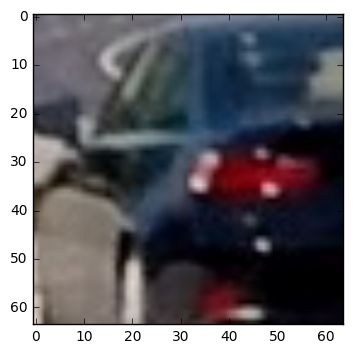

In [73]:
t=time.time()
image = mpimg.imread('./test_images/test4.jpg').astype(np.float32)/255
t=time.time()
boxes = random_scan_boxes(image, far = 40, mid = 20, near = 10)
find_car_img = []
find_car_boxes = []
for box in boxes:
    #print (box[0], box[0][0],box[0][1],box[1][0], box[1][1])
    x1,y1,x2,y2 = box[0][0],box[0][1],box[1][0], box[1][1]
    
    crop = image[y1:y2,x1:x2]  #Normalize .jpg image from 0-255 to 0-1
    resize_img = cv2.resize(crop, (64,64))

    test_feature = single_img_features(resize_img, color_space=params.colorspace, orient=params.orient,\
                                       pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block,\
                                       hog_channel=params.hog_channel,\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)

    scaled_test = X_scaler.transform(test_feature)

    if svc.predict(scaled_test) == 1:
        find_car_img.append(crop)
        find_car_boxes.append(box)
        plt.imshow(crop)
t2=time.time()
print(round(1/(t2-t), 1), 'fps')
print (len(find_car_boxes), find_car_boxes)


In [326]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    global labeled_bboxes
    labeled_bboxes = []
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/405      # approx meters per pixel in y dimension
    xm_per_pix = 3.7/500     # approx meteres per pixel in x dimension
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,255,255), 4)
        distance = np.sqrt(((bbox[0][0]-640)*xm_per_pix)**2+((bbox[0][1]-780)*ym_per_pix)**2)
        cv2.putText(img,'Car%s:%.1fm' % (car_number, distance),\
                    (int(bbox[0][0]-10),int(bbox[0][1]-20)), font, 1,(255,255,255),2)
        labeled_bboxes.append((car_number,bbox))
        
    # Return the image
    return img


In [327]:
def car_finder_pipeline(img):
    t=time.time()
    image = img.astype(np.float32)/255 #Normalize .jpg image from 0-255 to 0-1
    t=time.time()
    boxes = random_scan_boxes(image, far = 40, mid = 20, near = 10)
    find_car_img = []
    find_car_boxes = []
    for box in boxes:
        
        x1,y1,x2,y2 = box[0][0],box[0][1],box[1][0], box[1][1]
    
        crop = image[y1:y2,x1:x2]  
        resize_img = cv2.resize(crop, (64,64))

        test_feature = single_img_features(resize_img, color_space=params.colorspace, orient=params.orient,\
                                           pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block,\
                                           hog_channel=params.hog_channel,\
                                           spatial_feat=True, hist_feat=True, hog_feat=True)

        scaled_test = X_scaler.transform(test_feature)

        if svc.predict(scaled_test) == 1:
            find_car_img.append(crop)
            find_car_boxes.append(box)
            # plt.imshow(crop)
            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,find_car_boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # from scipy.ndimage.measurements import label
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = draw_labeled_bboxes(img, labels)
    
    
    t2=time.time()
    
    return draw_img
    

In [328]:
write_output = './test_video_out34.mp4'
clip1 = VideoFileClip('./test_video.mp4')
write_clip = clip1.fl_image(car_finder_pipeline)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)


[MoviePy] >>>> Building video ./test_video_out34.mp4
[MoviePy] Writing video ./test_video_out34.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out34.mp4 

CPU times: user 20.9 s, sys: 72 ms, total: 21 s
Wall time: 21.9 s


In [329]:
HTML("""
<video width="720" height="405" controls>
  <source src="{0}">
</video>
""".format(write_output))

In [78]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This was Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])


Using TensorFlow backend.


In [ ]:
### Train the Neural Network, and save the weights for futher use

model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("localize.h5")

In [79]:
heatmodel = get_conv(input_shape=(None,None,3), filename="localize.h5")

In [307]:
def locate(img, windows = None):
    
    
    heatmap = heatmodel.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
    
    location = []
    
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
        
    # Draw the box onto the blank image
    map_zero = np.zeros_like(img).astype(np.uint8)
    if len(windows) != 0:
        for win in windows:
            x1, y1, x2, y2 = win[0][0], win[0][1], win[1][0], win[1][1]
            for i,j in zip(x,y):
                # detection window within search windows
                if min(x1,x2)< i*8+32 < max(x1,x2) and min(y1,y2)< j*8+32<max(y1,y2):
                    cv2.rectangle(map_zero, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 1)
                    location.append(([i*8,j*8],[i*8+64, j*8+64]))
    return map_zero, location

In [81]:
def k_means(img, X, n_clusters=4): 
    if len(X) > n_clusters:
        t0 = time.time()
        k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
        k_means.fit(X)
        k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
        k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
        t_batch = time.time() - t0
        print (k_means_cluster_centers)
        print (k_means_labels)
        print (t_batch)
        dist = []
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/405 # meters per pixel in y dimension
        xm_per_pix = 3.7/500 # meteres per pixel in x dimension
        box = k_means_cluster_centers
        font = cv2.FONT_HERSHEY_SIMPLEX
        #for k in k_means_labels:
        for k in range(len(box)):
            k_res = cv2.rectangle(img, (int(box[k][0]-25),int(box[k][1]-25)), \
                                     (int(box[k][0]+100),int(box[k][1]+50)), (255,255,255), 6)
            curve = cv2.line(img, (int(box[k][0]),int(box[k][1]+50)), (640, 780), color=[255,255,255], thickness=4)
            distance = np.sqrt(((box[k][0]-640)*xm_per_pix)**2+((box[k][1]-780)*ym_per_pix)**2)
            dist.append(distance)
            cv2.putText(img,'Car%s:%.1fm' % (k, distance),\
                        (int(box[k][0]-30),int(box[k][1]-40)), font, 1,(255,255,255),2)
    return k_res, k_means_cluster_centers, k_means_labels, dist

2.5 fps


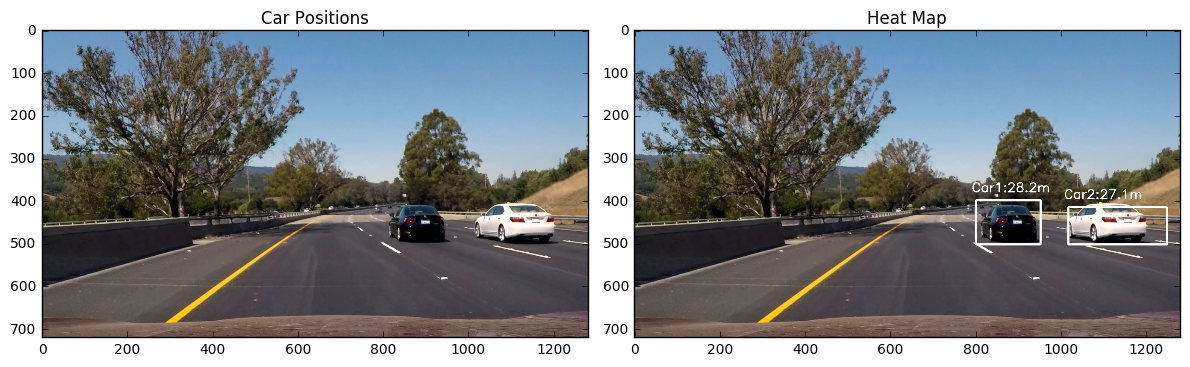

In [330]:
t=time.time()
full_img = mpimg.imread('./test_images/test6.jpg')
windows = random_scan_boxes(image, far = 20, mid = 20, near = 5)

heatmap_NN, location = locate(full_img, windows=windows)


# Add heat to each box in box list


heat = add_heat(heat,location)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

#from scipy.ndimage.measurements import label
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(full_img), labels)

t2=time.time()
print(round(1/(t2-t), 1), 'fps')
#print (location)
#plt.imshow(heatmap_NN)

fig = plt.figure(figsize=(12,5))
#fig = plt.figure(12,5)
plt.subplot(121)
plt.imshow(full_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(draw_img, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [152]:
def add_more_heat(heatmap, slide_windows=None, location=None):
    global combined_boxes
    combined_boxes = []
    # Iterate through slide windows list: 
    if len(slide_windows) != 0:
        for window in slide_windows:
            # Iterate through list of bboxes
            for box in location:
                # Add += 1 for all pixels inside each bbox
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                if min(window[0][0],window[1][0])< np.mean(box[0][0],box[0][0])< max(window[0][0],window[1][0]):
                    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
                    combined_boxes.append(((box[0][1],box[1][1]), (box[0][0],box[1][0])))
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [331]:
def NN_pipeline(image):
    t=time.time()
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/405      # approx meters per pixel in y dimension
    xm_per_pix = 3.7/500     # approx meteres per pixel in x dimension
    font = cv2.FONT_HERSHEY_SIMPLEX
    # copy a image to draw final output    
    f_image = np.copy(image)
    
    global location, heatmap_NN, heat, find_car_boxes, labeled_bboxes, draw_img
    marker = cv2.resize(pipeline(image), (1280, 720))
    heat = np.zeros_like(marker[:,:,0]).astype(np.float)
    
    #heat = add_heat(marker, location)
    if len(labeled_bboxes) == 0:
    #if len(find_car_boxes) == 0:
        # Apply random scanning windows 
        windows = random_scan_boxes(image, far = 20, mid = 20, near = 5)
        # Use Neroual Network to find car and heatmap
        heatmap_NN, location = locate(image, windows)
        # Add heat to each box in box list
        #heat = add_more_heat(heat, find_car_boxes, location)
        heat = add_heat(heat, location)
    
        # Apply threshold to help remove false positives
    
        heat = apply_threshold(heat,1.5)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # from scipy.ndimage.measurements import label
        # Find final boxes from heatmap using label function
        labels = label(heatmap_NN)
        #draw_img = draw_labeled_bboxes(np.copy(image), labels)
        draw_img = draw_labeled_bboxes(f_image, labels)
    else:
        
        norm_image = image.astype(np.float32)/255 #Normalize .jpg image from 0-255 to 0-1
        
        #boxes = random_scan_boxes(image, far = 20, mid = 10, near = 5)
        find_car_img = []
        find_car_boxes = []
        for box in labeled_bboxes:
        #for box in boxes:
        
            x1,y1,x2,y2 = box[1][0][0],box[1][0][1],box[1][1][0], box[1][1][1]
            #x1,y1,x2,y2 = box[0][0],box[0][1],box[1][0], box[1][1]
    
            crop = norm_image[y1:y2,x1:x2]  
            resize_img = cv2.resize(crop, (64,64))

            test_feature = single_img_features(resize_img, color_space=params.colorspace, orient=params.orient,\
                                               pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block,\
                                               hog_channel=params.hog_channel,\
                                               spatial_feat=True, hist_feat=True, hog_feat=True)

            scaled_test = X_scaler.transform(test_feature)

            if svc.predict(scaled_test) == 1:
                #font = cv2.FONT_HERSHEY_SIMPLEX
                distance = np.sqrt(((box[1][0][0]-640)*xm_per_pix)**2+((box[1][0][1]-780)*ym_per_pix)**2)
                draw_img = cv2.putText(f_image,'Car%s:%.1fm' % (box[0], distance),\
                                       (int(box[1][0][0]-10),int(box[1][0][1]-20)), font, 1,(255,255,255),2)
                cv2.rectangle(draw_img, box[1][0], box[1][1], (255,255,255), 4)
                #find_car_img.append(crop)
                find_car_boxes.append(box)
            else: 
                labeled_bboxes = []   # Reset the pipeline
            
    t2=time.time()
    
    return draw_img

In [332]:
labeled_bboxes = []
write_output = './project_video_out35.mp4'
clip1 = VideoFileClip('./project_video.mp4')
write_clip = clip1.fl_image(NN_pipeline)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)


[MoviePy] >>>> Building video ./project_video_out35.mp4
[MoviePy] Writing video ./project_video_out35.mp4


100%|█████████▉| 1260/1261 [02:53<00:00,  8.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out35.mp4 

CPU times: user 14min 43s, sys: 1min 26s, total: 16min 10s
Wall time: 2min 54s


In [333]:
HTML("""
<video width="720" height="405" controls>
  <source src="{0}">
</video>
""".format(write_output))

In [335]:
#print (location)
print (find_car_boxes)
print (labeled_bboxes)



[(1, ((1192, 392), (1279, 480))), (2, ((760, 400), (872, 488)))]
[(1, ((1192, 392), (1279, 480))), (2, ((760, 400), (872, 488)))]


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This was Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])


Using TensorFlow backend.


In [9]:

heatmodel = get_conv(input_shape=(None,None,3), filename="localize.h5")
# that is it!

In [15]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

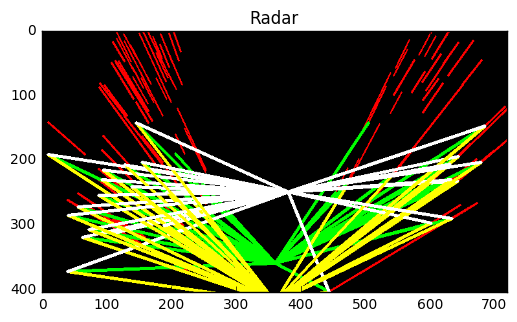

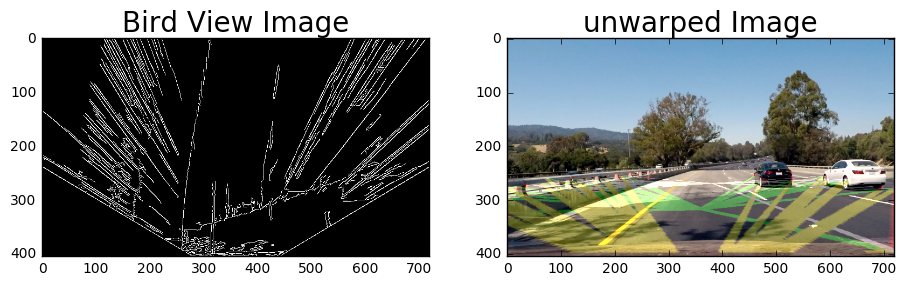

In [11]:
def locate(data):
    
    
    heatmap = heatmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    
    #plt.imshow(heatmap[0,:,:,0])
    #plt.title("Heatmap")
    #plt.show()
    #plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    #plt.title("Car Area")
    #plt.show()
    location = []
    
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    location.append([x,y])
    
    #print(x)
    #print(y)
    # Draw the lane onto the warped blank image
    warp_zero = np.zeros_like(data).astype(np.uint8)
    
    for i,j in zip(x,y):
        cv2.rectangle(warp_zero, (i*8,j*8), (i*8+32,j*8+64), (0,0,255), 1)
    return warp_zero, location

img = mpimg.imread("./test_images/test4.jpg")
rows, cols, chs = img.shape
img = cv2.resize(img,(int(cols*scale),int(rows*scale)))
#img = cv2.resize(img,(720,405))
undist = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

warped = perspective_transform(img, M)
warped_scale = cv2.resize(warped,(720,1620))
warp_zero = locate(warped)
canny = cv2.Canny(warped, 30, 150)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 10     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 30 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
#line_image = np.copy(image)*0 # creating a blank to draw lines on

hough, lines = hough_lines(canny, rho, theta, threshold, min_line_len, max_line_gap)
display = cv2.addWeighted(warped, 1, hough, 0.3, 0)

# Iterate over the output "lines" and draw lines on a blank image
slope = []
bottom_points = []

for line in lines:
    for x1,y1,x2,y2 in line:
        if (x2-x1) != 0:
            if abs((y2-y1)/(x2-x1))< 12 and min(y1,y2)>100 :
                bottom_points.append([min(x1,x2),max(y1,y2)])
        

for x1,y1 in bottom_points:
    radar = cv2.line(hough, (x1, y1), (360, 360), color=[0,255,0], thickness=4)

curve_points = []

for line in lines:
    for x1,y1,x2,y2 in line:
        if (x2-x1) != 0:
            if -1.9<(y2-y1)/(x2-x1)< 1.9 and min(y1,y2)>100 :
                curve_points.append([min(x1,x2),max(y1,y2)])
    
for x1,y1 in curve_points:
    curve = cv2.line(hough, (x1, y1), (360, 420), color=[255,255,0], thickness=4)
    
    #following camera
    pred = cv2.line(hough, (x1, y1), (380, 250), color=[255,255,255], thickness=4)
    #Top camera
    #top = cv2.line(hough, (x1, y1), (x1+1000, y1-2000), color=[0,255,255], thickness=40)
    #
# Warp back to original view
#unwarp = perspective_transform(warp_zero, Mi)
unwarp = perspective_transform(radar, Mi)

# Combine the result with the original image
result = cv2.addWeighted(img, 1, unwarp, 0.3, 0)
    

plt.title("Radar")    
plt.imshow(radar, cmap='gray')
plt.show()

#plt.title("Augmented")    
#plt.imshow(pred, cmap='gray')
#plt.show()
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(canny, cmap='gray')
ax1.set_title('Bird View Image', fontsize=20)
ax2.imshow(result)
ax2.set_title('unwarped Image', fontsize=20)

In [12]:
def draw_bboxes(img, box=64, max_cars = 16):
    heatmap, location = locate(img)
    
    if len(location)!=0:
        x = location[0][0]
        y = location[0][1]
        cars = []
        carx = []
        k = 0
        pointer_x = 0
        pointer_y = 0
        for i,j in zip(x,y):
            #if abs(i*8-pointer_x)>15 and abs(j*8-pointer_y)>15:
            if abs(i*8-pointer_x)>65 and j*8> 350:
                cv2.rectangle(img, (i*8,j*8), (i*8+box,j*8+box), (255,255,0), 6)
                carx.append([i*8,j*8])
                cars.append(k)
                pointer_x = i*8
                pointer_y = j*8
                #print (pointer_x, k)
                k= k+1
            
            # Define a bounding box based on min/max x and y        
            #bbox = ((int(i*8), int(j*8)), (int(i*8+32), int(j*8+box_size)))        
            # Draw the box on the image
            #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
        
    # Return the image    
    return img,carx,cars

In [100]:
def k_means(img, X, n_clusters=4): 
    if len(X) > n_clusters:
        t0 = time.time()
        k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
        k_means.fit(X)
        k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
        k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
        t_batch = time.time() - t0
        print (k_means_cluster_centers)
        print (k_means_labels)
        print (t_batch)
        dist = []
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/405 # meters per pixel in y dimension
        xm_per_pix = 3.7/500 # meteres per pixel in x dimension
        box = k_means_cluster_centers
        font = cv2.FONT_HERSHEY_SIMPLEX
        #for k in k_means_labels:
        for k in range(len(box)):
            k_res = cv2.rectangle(img, (int(box[k][0]-25),int(box[k][1]-25)), \
                                     (int(box[k][0]+100),int(box[k][1]+50)), (255,255,255), 6)
            curve = cv2.line(img, (int(box[k][0]),int(box[k][1]+50)), (640, 780), color=[255,255,255], thickness=4)
            distance = np.sqrt(((box[k][0]-640)*xm_per_pix)**2+((box[k][1]-780)*ym_per_pix)**2)
            dist.append(distance)
            cv2.putText(img,'Car%s:%.1fm' % (k, distance),\
                        (int(box[k][0]-30),int(box[k][1]-40)), font, 1,(255,255,255),2)
    return k_res, k_means_cluster_centers, k_means_labels, dist


[[  836.57142857   421.71428571]
 [ 1121.33333333   429.33333333]]
[0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1]
0.012518882751464844
[26.57951642878302, 26.218381971376271]


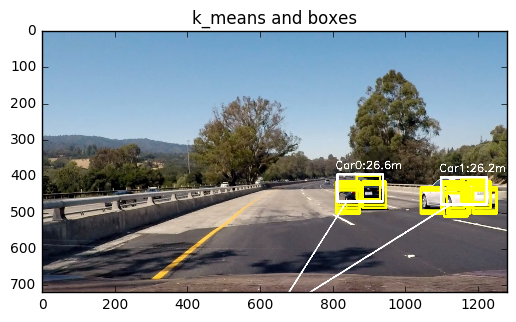

In [109]:
t0 = time.time()
full_img = mpimg.imread("./test_images/test4.jpg")
#t0 = time.time()
heatmap, location = locate(full_img)
#print(location[0])
#heatmap = locate(full_img)
#histogram = np.sum(location_x[:,:], axis=0)
#t0 = time.time()        
lable, carx, cars = draw_bboxes(full_img, 64)
n_clusters = 2
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/405 # meters per pixel in y dimension
xm_per_pix = 3.7/500 # meteres per pixel in x dimension
k_result, k_means_cluster_centers, k_means_labels, dist = k_means(full_img, carx, n_clusters)
#box = k_means_cluster_centers
#plt.title("heat map and boxes")    
#plt.imshow(lable, cmap='gray')
#plt.show()
#distance = np.sqrt(((box[k][0]-640)*xm_per_pix)**2+((box[k][1]-780)*ym_per_pix)**2)
#dist.append(distance)
print (dist)
                           
plt.title("k_means and boxes")    
plt.imshow(k_result)
plt.show()

#print (left_arcx)
#plt.plot(location[0][0]*8, location[0][1]*8, color='blue')
#plt.plot(right_arcx_pt, yvals, color='red')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

In [105]:
def pipeline(img):
    #img = cv2.resize(img, (720, 405))
    #img = cv2.undistort(img, mtx, dist, None, mtx)
    #warped = perspective_transform(img, M)
    heatmap, location = locate(img)
    lable, carx, cars = draw_bboxes(img, 64)
    n_clusters = 4
    k_res, k_means_cluster_centers, k_means_labels = k_means(img, carx, n_clusters)
    
    # Draw the lane onto the warped blank image
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    #cv2.polylines(warp_zero, np.array([pts_left], dtype=np.int32), False,(255,0,0),thickness = 15)
    #cv2.polylines(warp_zero, np.array([pts_right], dtype=np.int32), False,(0,0,255),thickness = 15)
    #font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    #font = cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(img,'Left curve' + ' ' + str(left_curverad)[:6] + 'm',(10,60), font, 1,(255,255,255),1)
    #cv2.putText(img,'Car''15 m',(10,30), font, 1,(255,255,255),2)
    #cv2.putText(img,'Turning Radius ' +str(turning_radius)[:6] + '] m' ,(10,60), font, 1,(255,255,255),2)
    #cv2.putText(img, 'Turning Radius = %.2f m' % np.array(turning_radius), (10, 40), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    #cv2.putText(img,'Steering Angle '+'{:.6}'.format(str(steering_angle)) + '] deg',(10,90), font, 1,(255,255,255),2)
    
    # Warp back to original view
    unwarp = perspective_transform(warped, Mi)
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, unwarp, 0.3, 0)
    #result = cv2.resize(result, (720, 405))

    return k_res

    

In [106]:
# Read in an image
image = mpimg.imread('test_images/test6.jpg')
image = cv2.resize(image,(720,405))

apex, apey = 360, 210
offset_far = 170
offset_near = -750
src = np.float32([[int(apex-offset_far),apey],
                  [int(apex+offset_far),apey],
                  [int(0+offset_near),390],
                  [int(720-offset_near),390]])
dst = np.float32([[0,0],[720,0],[0,405],[720,405]])
M = cv2.getPerspectiveTransform(src, dst)
Mi = cv2.getPerspectiveTransform(dst, src)

result = pipeline(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(result,cmap='gray' )
ax2.set_title('Output', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


UnboundLocalError: local variable 'k_res' referenced before assignment

In [13]:
import os

images = os.listdir('./object-detection-crowdai')  

for fname in images:
    fname = os.path.join('object-detection-crowdai', fname)
    ret = True
    image = cv2.imread(fname)
    image = cv2.resize(image,(720,405))
    warped = perspective_transform(image, M)
    result = pipeline(image)
    
    if ret == True:

        # Draw and display the corners
        #cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('combined filter image', warped)
        #cv2.imshow('combined filter image', result)
        
        cv2.waitKey(1000)
    
cv2.destroyAllWindows()

KeyboardInterrupt: 